In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Automatic Image segmentation:

Let's consider an image segmentation problem in which we should identify a pattern from the background. In this case, we only have two classes of pixels: pixels belonging to the background and pixels belonging to the pattern of interest.

In order to understand the different methods covered in this session, we are going to use two different images from a well known dataset on retinal vessel segmentation:

- **Training image** ('vessels_train.jpg'): The one we are using in order to design the sementation method
- **Test iamge** ('vessels_test.jpg'): The image we are going to use in order to test the previously designed segmentation approach

For each of the images we also have their corresponding ground truth sementation images obtained from an independent expert ('vessels_train_GT.tif' and 'vessels_test_GT.tif'). We will use them as reference in order to quantify the performance of the sementation method. First we take a look to the image dataset: 

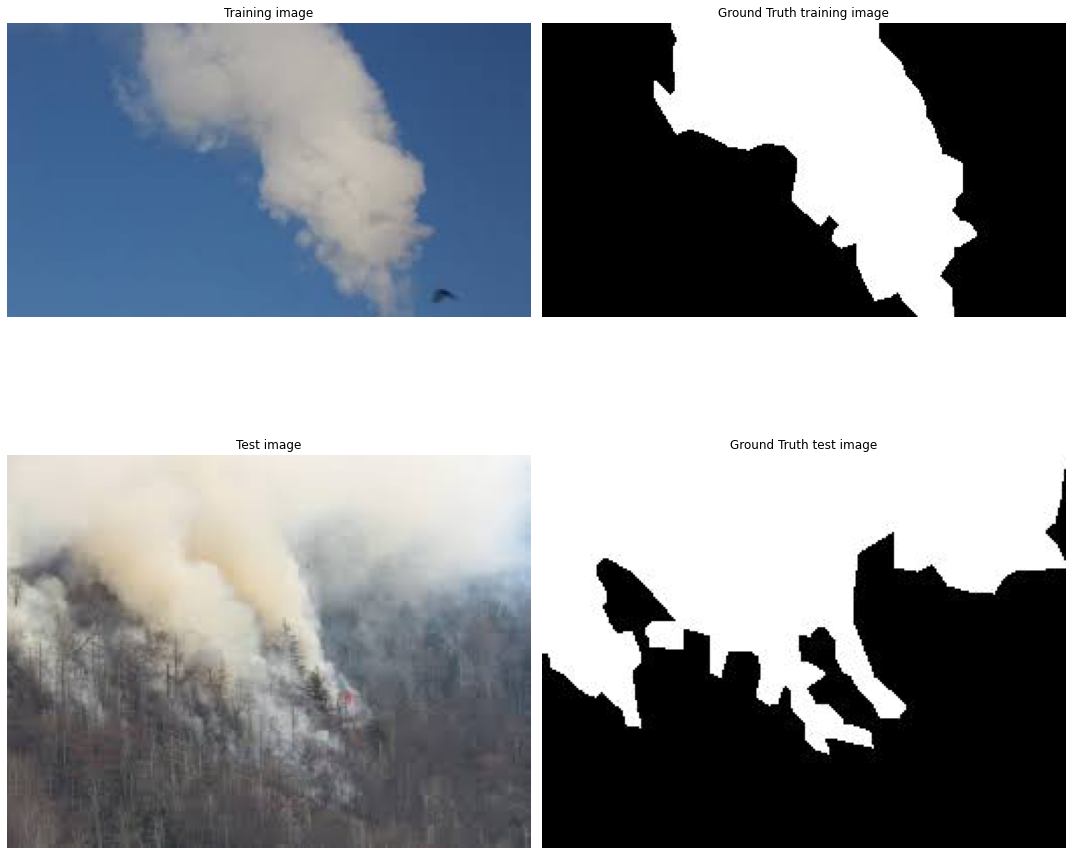

In [2]:
import skimage as sk 
import matplotlib.pyplot as plt
from skimage import io
import os 
from matplotlib import gridspec
import numpy as np

path_img = '/content/drive/MyDrive/TFM/codi/IMAGE/dataset/images'
path_mask = '/content/drive/MyDrive/TFM/codi/IMAGE/dataset/masks'

I_train = sk.io.imread(os.path.join(path_img,'smoke_(221).jpg')) 
I_train_GT = sk.io.imread(os.path.join(path_mask,'smoke_(221).png')) 
I_test = sk.io.imread(os.path.join(path_img,'smoke_(228).jpg'))
I_test_GT = sk.io.imread(os.path.join(path_mask,'smoke_(228).png'))
 
fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0,0])
ax0.imshow(I_train, cmap=plt.cm.gray)
ax0.set_title('Training image')
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(I_train_GT, cmap=plt.cm.gray)
ax1.set_title('Ground Truth training image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[1,0])
ax2.imshow(I_test, cmap=plt.cm.gray)
ax2.set_title('Test image')
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,1])
ax3.imshow(I_test_GT, cmap=plt.cm.gray)
ax3.set_title('Ground Truth test image')
ax3.set_axis_off()

plt.tight_layout()
plt.show()

In [3]:
I_train.shape

(168, 300, 3)

In [4]:
import cv2
I_train = cv2.cvtColor(I_train, cv2.COLOR_BGR2GRAY) # convert it to grayscale

In [5]:
I_train.shape

(168, 300)

# Manual thresholding:

A straightforward segmentation approach would be setting a manual grayscale trheshold after inspection of the image histogram:

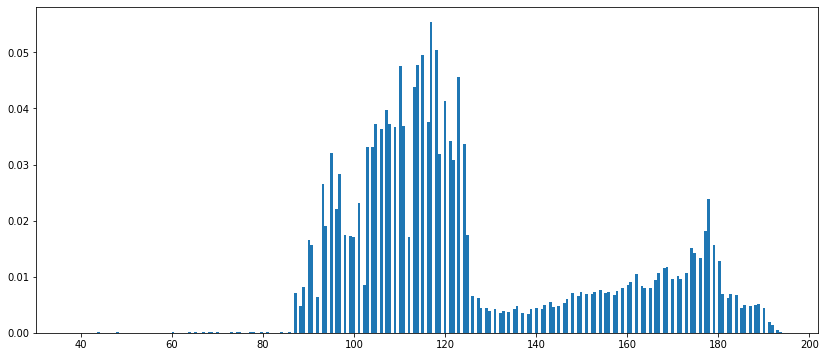

In [6]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# reshape training image as 1d array:
v_I_train = I_train.reshape(I_train.shape[0]*I_train.shape[1],1).astype(np.uint8)   #image saved as an integer of 8 bits (uint8)

fig = plt.figure(figsize=(14, 6))
plt.hist(v_I_train, bins=256,density=True)  #histogram of the image
plt.show()

since we observe two clear clusters in the histogram we can separate them using a threshold of around 130:

In [7]:
# Find Otsu's threshold for training image:
threshold_manual = 130

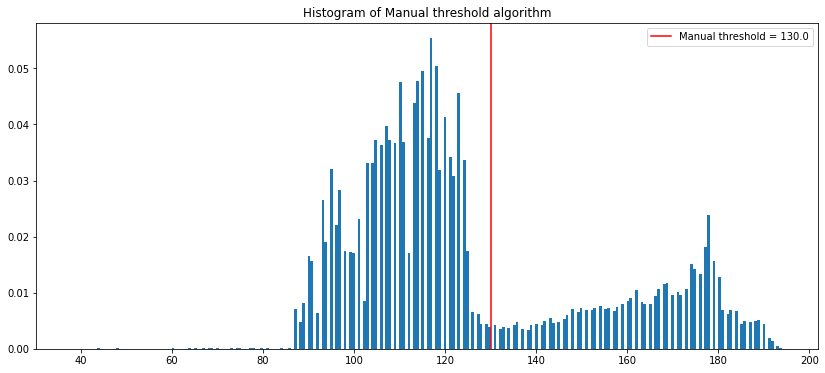

In [8]:
fig = plt.figure(figsize=(14, 6))
plt.hist(v_I_train, bins=256,density=True)  #histogram of the image
plt.axvline(threshold_manual, color='r', label=('Manual threshold = ' + str(np.mean(threshold_manual))))
plt.title("Histogram of Manual threshold algorithm")
plt.legend()
plt.show()


In [9]:
I_test.shape

(194, 259, 3)

In [10]:
I_test = cv2.cvtColor(I_test, cv2.COLOR_BGR2GRAY) # convert it to grayscale
I_test.shape

(194, 259)

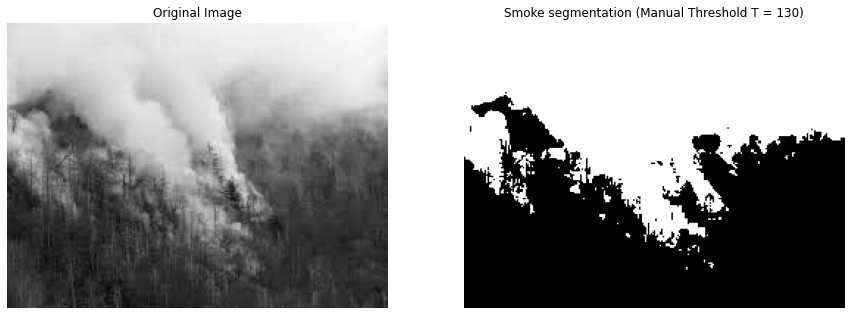

In [11]:
# Apply manual threshold to test image (Image Binarization):
I_manual = I_test >= threshold_manual   #create a mask which is a boolean condition: test image is larger than the manual threshold


fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_manual, cmap=plt.cm.gray)
ax2.set_title('Smoke segmentation (Manual Threshold T = {})'.format(threshold_manual))
ax2.set_axis_off()

plt.show()

## Otsu's Algorithm:

The first automatic segmentation approach is the Otsu's Method. 

otsu.png![image.png](attachment:image.png)

The algorithm finds the threshold that **maximum inter-class variance** $\sigma _{b}^{2}(t)$, defined in terms of the difference between the means of the two clusters in the image histogram (pattern and background, respectively):

$\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$ 

The algorithm is the following: 

1. Compute histogram and probabilities of each intensity level $p(i), i=0,\dots L$ where $L=2^n$ for an n-bit grayscale image.

2. Set up initial $\omega _{i}(0)$ and $\mu _{i}(0)$ 

3. Step through all possible thresholds $t=1,\ldots L-1$ 

a) Update $\omega _{i}$ and $\mu _{i}$


$\omega _{0}(t)=\sum _{i=0}^{t-1}p(i)$

$\omega _{1}(t)=\sum _{i=t}^{L-1}p(i)$

$\mu _{0}(t)={\frac {\sum _{i=0}^{t-1}ip(i)}{\omega _{0}(t)}}$

$\mu _{1}(t)={\frac {\sum _{i=t}^{L-1}ip(i)}{\omega _{1}(t)}}$

b) Compute $\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$ 

4. Desired threshold corresponds to the maximum inter-class variance $\sigma _{b}^{2}(t)$ 

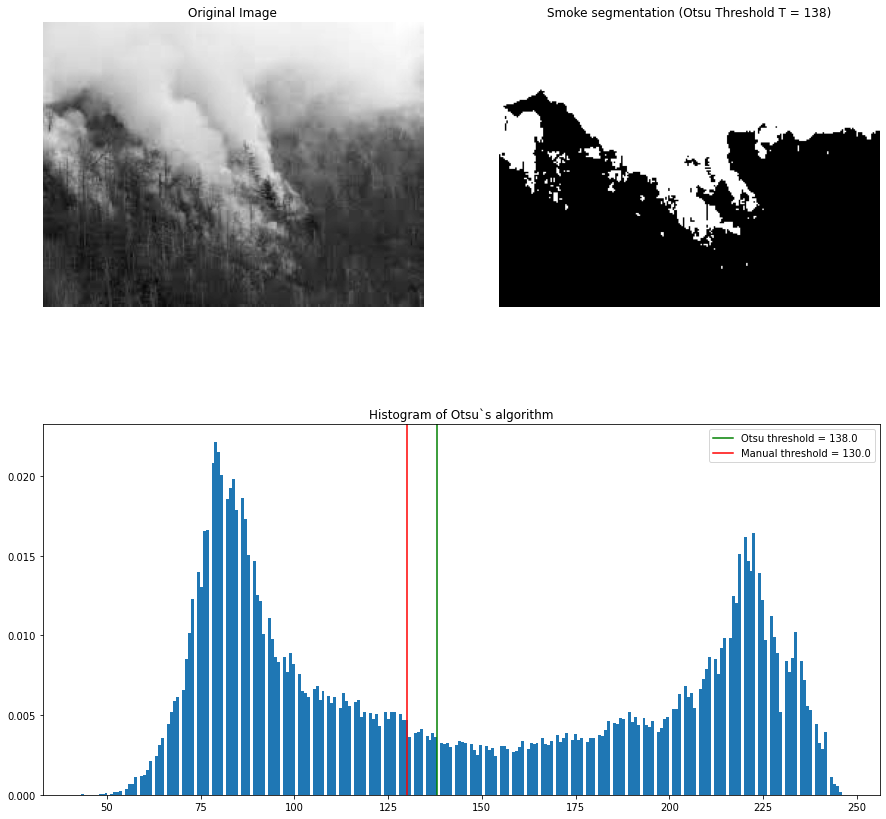

In [12]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from skimage.filters import threshold_otsu
import numpy

# Find Otsu's threshold for training image:
threshold_otsu = threshold_otsu(I_train)

# Apply threshold to test image:
I_otsu = I_test >= threshold_otsu

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_otsu, cmap=plt.cm.gray)
ax2.set_title('Smoke segmentation (Otsu Threshold T = {})'.format(threshold_otsu))
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,:])
ax3.hist(I_test.ravel(), bins=256,density=True)
ax3.axvline(threshold_otsu, color='g', label=('Otsu threshold = ' + str(numpy.mean(threshold_otsu))))
ax3.axvline(threshold_manual, color='r', label=('Manual threshold = ' + str(numpy.mean(threshold_manual))))
ax3.set_title("Histogram of Otsu`s algorithm")
ax3.legend()
plt.show()

In [13]:
threshold_otsu

138

# Segmentation methods using clustering algorithms: 

Tehre are many Artificial Intelligence methods devoted to **automatic data clustering**. In our case clusters correspond to pixels belonging to the pattern and to the background. They are **Usupervised methods** that do not require the use of the ground truth in order to obtain a suitable segmentation. 

The most common ones arethe following: 

- Kmeans clustering
- Hierarchical clustering
- Gaussian Mixture models

We are going to focus in the kmeans clustering, we first explain how it works and then we are going to apply kmeans clustering to our vessel semgnetation problem. At the end of the section we provide some details on Hierarchical clustering and Gaussian Mixture models. 

## kmeans algorithm:

[1] Specify the number of clusters $k$ to be found in data.

[2] Set initial values for the cluster centroids $\mu^0_1,\dots,\mu^0_k$ (at random or prior knowledge). 

[3] Assign each observation to the nearest cluster (euclidean distance).

[4] Recompute the centroid of each cluster from the assigned observations $\mu^1_1,\dots,\mu^1_k$.

[5] Repeat steps 3-4 until no change in the centroids. Provide final clustering $\mu^n_1,\dots,\mu^n_k$, where $n$ is the number of iterations.

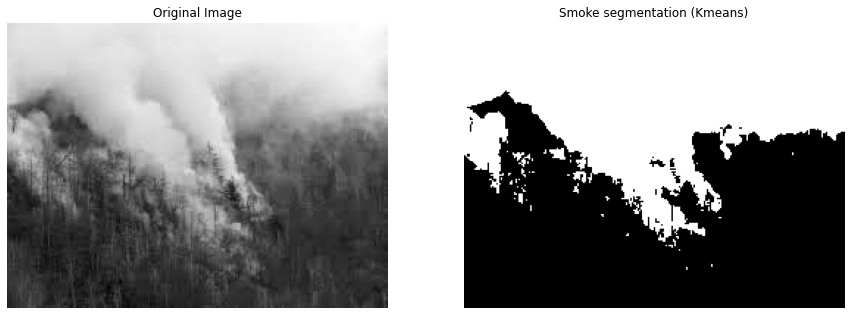

In [14]:
from sklearn.cluster import KMeans  #replace by the model we want

# reshape training image as 1d array:
v_I_train = I_train.reshape(I_train.shape[0]*I_train.shape[1],1).astype(np.uint8) 

# Fit a Kmeans clustering model with two clusters using training image:
kmeans = KMeans(n_clusters=2, random_state=0).fit(v_I_train)

# Apply to predict test image:
v_I_test = I_test.reshape(I_test.shape[0]*I_test.shape[1],1).astype(np.uint8) # reshape image as 1d array

v_kmeans = kmeans.predict(v_I_test) #predict the test image
#v_kmeans= np.logical_not(v_kmeans)   #invert to have the background in white and the vessels in black
I_kmeans = np.array(v_kmeans).reshape(I_test.shape[0],I_test.shape[1]).astype(np.uint8) # Shape back result as image 


fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_kmeans, cmap=plt.cm.gray)
ax2.set_title('Smoke segmentation (Kmeans)')
ax2.set_axis_off()

plt.show()

## Evaluating segmentation algorithms:

In order to evaluate a segmentation algorithm, we should introduce the following quantities:

- True positive (TP): A pattern pixel that has been correctly segmented as pattern
- True negative (TN): A background pixel that has been correctly segmented as background
- False positive (FP): A background pixel that has been mistakenly segmented as pattern (false alarm, Type I error)
- False negative (FN): A pattern pixel that has been mistakenly segmented as background (omission, Type II error)

The confusion matrix is a 2x2 matrix reporting these four values: TP,TNFP,FN. 

From them we can define different measures of error: 

- Sensitivity, recall, hit rate, or true positive rate (TPR):

## $\text{TPR} =\frac{TP}{TP+FN}$

- Specificity, selectivity or true negative rate (TNR):

## $\text{TNR} =\frac{TN}{TN+FP}$

- The Sorensen-Dice similarity index: 

Measures the similarity between a segmentation mask and the ground truth mask by computing the F1 score
is the harmonic mean of precision and sensitivity:

$\text{DSC}={\frac {2TP}{2TP+FP+FN}}$.

Let's compute these magnitudes for each of the segmentation methods:

In [15]:
from sklearn.metrics import confusion_matrix

v_test_GT = I_test_GT.reshape(I_test_GT.shape[0]*I_test_GT.shape[1],1).astype(np.bool) 

v_manual = I_manual.reshape(I_manual.shape[0]*I_manual.shape[1],1).astype(np.bool) 
CM_manual = confusion_matrix(v_test_GT,v_manual)
tn, fp, fn, tp = CM_manual.ravel()
TPR_manual = tp/(tp+fn)
FPR_manual = fp/(fp+tn)
DSC_manual = 2*tp/(2*tp+fp+fn)

v_otsu = I_otsu.reshape(I_otsu.shape[0]*I_otsu.shape[1],1).astype(np.bool) 
CM_otsu = confusion_matrix(v_test_GT,v_otsu)
tn, fp, fn, tp = CM_otsu.ravel()
TPR_otsu = tp/(tp+fn)
FPR_otsu = fp/(fp+tn)
DSC_otsu = 2*tp/(2*tp+fp+fn)

CM_kmeans = confusion_matrix(v_test_GT,np.array(v_kmeans).astype(np.bool))
tn, fp, fn, tp = CM_kmeans.ravel()
TPR_kmeans = tp/(tp+fn)
FPR_kmeans = fp/(fp+tn)
DSC_kmeans = 2*tp/(2*tp+fp+fn)

print('Manual Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_manual,FPR_manual,DSC_manual))
print('Otsu Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_otsu,FPR_otsu,DSC_otsu))
print('Kmeans Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_kmeans,FPR_kmeans,DSC_kmeans))

Manual Segmentation: TPR=0.9082442938510789, FPR=0.11877219104340854, DSC=0.8914915323403387
Otsu Segmentation: TPR=0.884546626200474, FPR=0.09311648150269156, DSC=0.8908055602076704
Kmeans Segmentation: TPR=0.8816363863135576, FPR=0.09029129920207689, DSC=0.8905593818242903


<ipython-input-15-13ef2bced345>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  v_test_GT = I_test_GT.reshape(I_test_GT.shape[0]*I_test_GT.shape[1],1).astype(np.bool)
<ipython-input-15-13ef2bced345>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  v_manual = I_manual.reshape(I_manual.shape[0]*I_manual.shape[1],1).astype(np.bool)
<ipython-input-15-